<a href="https://colab.research.google.com/github/deltorobarba/machinelearning/blob/master/optimizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Optimizer**

In [ ]:
!pip install livelossplot --quiet
from livelossplot import PlotLossesKerasTF
import tensorflow as tf
print(tf.__version__)

2.3.0


https://algorithmia.com/blog/introduction-to-optimizers

https://juntang-zhuang.github.io/adabelief/

##### **Intro**

* why optimizer
* what is it doing

https://medium.com/explorations-in-language-and-learning/a-short-note-on-gradient-descent-optimization-algorithms-335546c5a896


An overview of gradient descent optimization algorithms

https://arxiv.org/pdf/1609.04747.pdf

**Which Optimizer to use?**

* Wich optimizer should you now use? If your input data is sparse, then you likely achieve the best results using one of the adaptive learning-rate methods. An additional benefit is that you won't need to tune the learning rate but likely achieve the best results with the default value.
* In summary, RMSprop is an extension of Adagrad that deals with its radically diminishing learning rates. It is identical to Adadelta, except that Adadelta uses the RMS of parameter updates in the numinator update rule. Adam, finally, adds bias-correction and momentum to RMSprop. Insofar, RMSprop, Adadelta, and Adam are very similar algorithms that do well in similar circumstances. Kingma et al. [15] show that its bias-correction helps Adam slightly outperform RMSprop towards the end of optimization as gradients become sparser. Insofar, Adam might be the best overall choice.
* Interestingly, many recent papers use vanilla SGD without momentum and a simple learning rate annealing schedule. As has been shown, SGD usually achieves to find a minimum, but it might take significantly longer than with some of the optimizers, is much more reliant on a robust initialization and annealing schedule, and may get stuck in saddle points rather than local minima. Consequently, if you care about fast convergence and train a deep or complex neural network, you should choose one of the adaptive learning rate methods.

**Comparison**

* Few days ago, an interesting paper titled The Marginal Value of Adaptive Gradient Methods in Machine Learning (https://arxiv.org/abs/1705.08292) from UC Berkeley came out. In this paper, the authors compare adaptive optimizer (Adam, RMSprop and AdaGrad) with SGD, observing that SGD has better generalization than adaptive optimizers.
* “We observe that the solutions found by adaptive methods generalize worse (often significantly worse) than SGD, even when these solutions have better training performance. These results suggest that practitioners should reconsider the use of adaptive methods to train neural networks.”
* I was astounded by their finding since I never used SGD before and consider it as an outdated optimizer with slower convergence than Adam or RMSprop. Am I totally wrong from the very beginning?

https://medium.com/vitalify-asia/whats-up-with-deep-learning-optimizers-since-adam-5c1d862b9db0


##### **Learning Rate**

In [ ]:
learning_rate = 0.001

https://machinelearningmastery.com/understand-the-dynamics-of-learning-rate-on-deep-learning-neural-networks/

* being used in optimizers / cost function
* Learning rate is an important component of backpropagation in a neural network:
* New Value of weight a = Old value a - (learning rate * gradient ∂SSE/∂a) θ=θ−η⋅∇θJ(θ)

**Ian Goodfellow answering to "Why do not use the whole training set to compute the gradient?" on Quora**

* The size of the learning rate is limited mostly by factors like how curved the cost function is. You can think of gradient descent as making a linear approximation to the cost function, then moving downhill along that approximate cost. 
* If the cost function is highly non-linear (highly curved) then the approximation will not be very good for very far, so only small step sizes are safe. You can read more about this in Chapter 4 of the deep learning textbook, on numerical computation: http://www.deeplearningbook.org/contents/numerical.html
* When you put m examples in a minibatch, you need to do O(m) computation and use O(m) memory, but you reduce the amount of uncertainty in the gradient by a factor of only O(sqrt(m)). In other words, there are diminishing marginal returns to putting more examples in the minibatch. You can read more about this in Chapter 8 of the deep learning textbook, on optimization algorithms for deep learning: http://www.deeplearningbook.org/contents/optimization.html
* Also, if you think about it, even using the entire training set doesn’t really give you the true gradient. The true gradient would be the expected gradient with the expectation taken over all possible examples, weighted by the data generating distribution. Using the entire training set is just using a very large minibatch size, where the size of your minibatch is limited by the amount you spend on data collection, rather than the amount you spend on computation.


**Reasons for using a Learning Rate**

* Prevent overreaction which can cause loss increase
* Neural networks are often trained by gradient descent on the weights. This means at each iteration we use backpropagation to calculate the derivative of the loss function with respect to each weight and subtract it from that weight. 
* However, if you actually try that, the weights will change far too much each iteration, which will make them “overcorrect” and the loss will actually increase/diverge. So in practice, people usually multiply each derivative by a small value called the “learning rate” before they subtract it from its corresponding weight.
* You can also think of a neural networks loss function as a surface, where each direction you can move in, represents the value of a weight. Gradient descent is like taking leaps in the current direction of the slope, and the learning rate is like the length of the leap you take.
* Learning rate decay os alternative to momentum: when replacing gradient descent with SDG, we take smaller, noisier steps towards objective (minimum).
* How small should steps be? Much research! Always: beneficial to make steps smaller and smaller; i.e. apply exponential decay to learning rate, others make smaller every time loss reaches a plateau

**Challenges**

* Which learning rate: If low, training is more reliable, but optimization will take a lot of time because steps towards the minimum of the loss function are tiny. If learning rate is high, then training may not converge or even diverge. Weight changes can be so big that the optimizer overshoots the minimum and makes the loss worse.
* A learning rate that is too small leads to painfully slow convergence, while a learning rate that is too large can hinder convergence and cause the loss function to fluctuate around the minimum or even to diverge.
* Which Cost function: with SSE cost function the value of θF(Wj)/θWj gets larger and larger as we increase the size of the training dataset
* Change learning rate during process? Upwards or downwards?
* Learning rate schedules [11] try to adjust the learning rate during training by e.g. annealing, i.e. reducing the learning rate according to a pre-defined schedule or when the change in objective between epochs falls below a threshold. These schedules and thresholds, however, have to be defined in advance and are thus unable to adapt to a dataset's characteristics [10].
* Additionally, the same learning rate applies to all parameter updates. If our data is sparse and our features have very different frequencies, we might not want to update all of them to the same extent, but perform a larger update for rarely occurring features.
* As full-scale hyperparameter optimization: Selecting a learning rate is a "meta-problem" (hyperparameter optimization). The best learning rate depends on the problem at hand, as well as on the architecture of the model being optimized, and even on the state of the model in the current optimization process! There are even software packages devoted to hyperparameter optimization such as spearmint and hyperopt (just a couple of examples, there are many others!)

**Cosine Annealing**

**Adapting learning rate in each iteration downwards (Annealing)**

Optimize is the learning rate during training. conventional: decrease over time. There are Multiple ways: step-wise learning rate annealing when the loss stops improving, exponential learning rate decay, cosine annealing, etc. [Source](
https://machinelearningmastery.com/using-learning-rate-schedules-deep-learning-models-python-keras/)

**Notes on adaptive**
* Adapt the value of λ in each iteration. The farther you are from optimal values the faster you should move towards the solution and value of λ should be larger. (The training should start from a relatively large learning rate because, in the beginning, random weights are far from optimal. Then decrease learning rate to allow more fine-grained weight updates.
* Check value of error function at the end of each iteration. If error rate reduced since last iteration, increase learning rate by 5%. If error rate increased (=skipped optimal point) reset values of Wj to values of previous iteration and decrease learning rate by 50%. This is called [Bold Driver](http://www.willamette.edu/~gorr/classes/cs449/momrate.html).
* One technique that's quite common for selecting learning rates: [Simulated annealing](https://en.wikipedia.org/wiki/Simulated_annealing): start with a large learning rate (0.1 or so) and gradually reduce learning rate as optimization progresses, often by an order of magnitude (0.01, then 0.001, 0.0001, etc.).
* Combine with [early stopping](https://en.wikipedia.org/wiki/Early_stopping) to optimize the model with one learning rate as long as progress is being made, then switch to a smaller learning rate once progress appears to slow. The larger learning rates appear to help the model locate regions of general, large-scale optima, while smaller rates help the model focus on one particular local optimum. If the loss does not decrease for several epochs, the learning rate might be too low. The optimization process might also be stuck in a local minimum.
* Weight update tracking: Andrej Karpathy proposed to track weight updates to check if the learning rate is well-chosen. If weight update is too high, then learning rate has to be decreased. If weight update is too low, then learning rate has to be increased.

**Approach 1: Drop-based learning rate schedule**
* Often this method is implemented by dropping the learning rate by half every fixed number of epochs.
* For example, we may have an initial learning rate of 0.1 and drop it by 0.5 every 10 epochs. The first 10 epochs of training would use a value of 0.1, in the next 10 epochs a learning rate of 0.05 would be used, and so on

**Approach 2: Time-based learning rate schedule**
* The learning rate for stochastic gradient descent has been set to a higher value of 0.1. 
* The model is trained for 50 epochs and the decay argument has been set to 0.002, calculated as 0.1/50. 
* Additionally, it can be a good idea to use momentum when using an adaptive learning rate. In this case we use a momentum value of 0.8.
* Increase the initial learning rate. Because the learning rate will very likely decrease, start with a larger value to decrease from. A larger learning rate will result in a lot larger changes to the weights, at least in the beginning, allowing you to benefit from the fine tuning later.
* Use a large momentum. Using a larger momentum value will help the optimization algorithm to continue to make updates in the right direction when your learning rate shrinks to small values.
* Experiment with different schedules. It will not be clear which learning rate schedule to use so try a few with different configuration options and see what works best on your problem. Also try schedules that change exponentially and even schedules that respond to the accuracy of your model on the training or test datasets

**Approach 3: Adapting learning rate in each iteration upwards**
* Leslie N. Smith describes a powerful technique to select a range of learning rates for a neural network in section 3.3 of the 2015 paper ["Cyclical Learning Rates for Training Neural Networks"](https://arxiv.org/abs/1506.01186) . 
* The trick is to train a network starting from a low learning rate and increase the learning rate exponentially for every batch

**Batch Size Incrase vs Learning Rate Decay**

*Don't Decay the Learning Rate, Increase the Batch Size*

* Paper: https://arxiv.org/abs/1711.00489
* It is common practice to decay the learning rate. Here we show one can usually obtain the same learning curve on both training and test sets by instead increasing the batch size during training. This procedure is successful for stochastic gradient descent (SGD), SGD with momentum, Nesterov momentum, and Adam. 
* It reaches equivalent test accuracies after the same number of training epochs, but with fewer parameter updates, leading to greater parallelism and shorter training times. We can further reduce the number of parameter updates by increasing the learning rate ϵ and scaling the batch size B∝ϵ. 
* Finally, one can increase the momentum coefficient m and scale B∝1/(1−m), although this tends to slightly reduce the test accuracy. Crucially, our techniques allow us to repurpose existing training schedules for large batch training with no hyper-parameter tuning. We train ResNet-50 on ImageNet to 76.1% validation accuracy in under 30 minutes.

##### **Momentum**

In [ ]:
momentum = 0.9 # for RMSProp 0.0 / for SGD 0.9


* [Why Momentum Really Works](https://distill.pub/2017/momentum/)

##### **Stochastic Gradient Descent**

In [ ]:
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, 
                                    momentum=momentum, 
                                    nesterov=False)

* [tf.keras](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/SGD) documentation & Nesterov algorithm based on [this paper](http://jmlr.org/proceedings/papers/v28/sutskever13.pdf)
* SGD is a stochastic approximation of the gradient descent optimization and iterative method for minimizing an objective function that is written as a sum of differentiable functions. All other optimizers are called „adaptive“, because they have momentum.
* A compromise between computing the true gradient and the gradient at a single example is to compute the gradient against more than one training example (called a "mini-batch") at each step. This can perform significantly better than "true" stochastic gradient descent described, because the code can make use of vectorization libraries rather than computing each step separately. It may also result in smoother convergence, as the gradient computed at each step uses more training examples.
* The convergence of stochastic gradient descent has been analyzed using the theories of convex minimization and of stochastic approximation. Briefly, when the learning rates decrease with an appropriate rate, and subject to relatively mild assumptions, stochastic gradient descent converges almost surely to a global minimum when the objective function is convex or pseudoconvex, and otherwise converges almost surely to a local minimum.[3][4] This is in fact a consequence of the Robbins-Siegmund theorem.
* SGD suffers from 2 problems: (i) being hesitant at steep slopes, and (ii) having same learning rate for all parameters.
* $\theta=\theta-\eta \cdot \nabla_{\theta} J\left(\theta ; x^{(i)} ; y^{(i)}\right)$
* Stochastic gradient descent (SGD) in contrast performs a parameter update for each training example $x^{(i)}$ and label $y^{(i)}$
* Batch gradient descent performs redundant computations for large datasets, as it recomputes gradients for similar examples before each parameter update. SGD does away with this redundancy by performing one update at a time. It is therefore usually much faster and can also be used to learn online. 
* SGD performs frequent updates with a high variance that cause the objective function to fluctuate heavily.

**SGD with Momentum**
* The update vector consists of another term which has the previous update vector (weighted by γ). This helps it to move faster downhill — like a ball.
* The momentum term γ is usually set to 0.9 or a similar value.
* $\begin{aligned}
v_{t} &=\gamma v_{t-1}+\eta \nabla_{\theta} J(\theta) \\
\theta &=\theta-v_{t}
\end{aligned}$
Source: [An overview of gradient descent optimization
algorithms](https://arxiv.org/pdf/1609.04747.pdf)

**SGD with NAG (Nesterov Accelerated Gradient)**
* In Momentum optimizer, the ball may go past the minima due to too much momentum, so we want to have a look-ahead term. 
* In NAG, we take gradient of future position instead of current position.
* $\begin{aligned}
v_{t} &=\gamma v_{t-1}+\eta \nabla_{\theta} J\left(\theta-\gamma v_{t-1}\right) \\
\theta &=\theta-v_{t}
\end{aligned}$

##### **Adam Optimizer**

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, 
                                     beta_1=0.9, 
                                     beta_2=0.999, 
                                     epsilon=1e-07, 
                                     amsgrad=False)

* "Adaptive Moment Estimation"
* Algorithm based on [this paper](https://arxiv.org/abs/1412.6980) & [tf.keras](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam) documentation
* The theory is that Adam already handles learning rate optimization ([Check paper](http://arxiv.org/pdf/1412.6980v8.pdf)) : "We propose Adam, a method for efficient stochastic optimization that only requires first-order gradients with little memory requirement. The method computes individual adaptive learning rates for different parameters from estimates of first and second moments of the gradients; the name Adam is derived from adaptive moment estimation."
* Adam optimization is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments. The method is computationally efficient, has little memory requirement, invariant to diagonal rescaling of gradients, and is well suited for problems that are large in terms of data/parameters.
* Adam can be looked at as a combination of RMSprop and Stochastic Gradient Descent with momentum. It uses the squared gradients to scale the learning rate like RMSprop and it takes advantage of momentum by using moving average of the gradient instead of gradient itself like SGD with momentum.

* $\theta_{t+1}=\theta_{t}-\frac{\eta}{\sqrt{\hat{v}_{t}+\epsilon}} \hat{m}_{t}$

* Adam combines RMSProp with Momentum. So, in addition to using the decaying average of past squared gradients for parameter-specific learning rate, it uses a decaying average of past gradients in place of the current gradient (similar to Momentum).
* The ^ terms are actually bias-corrected averages to ensure that the values are not biased towards 0.

##### **Nadam Optimizer**

In [ ]:
optimizer = tf.keras.optimizers.Nadam(learning_rate=learning_rate, 
                                      beta_1=0.9, 
                                      beta_2=0.999, 
                                      epsilon=1e-07)

* "Nesterov Adaptive Moment Estimation"
* Algorithm based on [this paper](http://cs229.stanford.edu/proj2015/054_report.pdf) & [tf.keras](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Nadam) documentation
* Nadam is Adam with Nesterov momentum

##### **RMSprop Optimizer**

In [ ]:
optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate, 
                                        rho=0.9, 
                                        momentum=momentum, 
                                        epsilon=1e-07, 
                                        centered=False)

* [tf.keras](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/RMSprop) documentation
* RMSprop is an unpublished optimization algorithm designed for neural networks, first proposed by Geoff Hinton in lecture 6 of the online course “Neural Networks for Machine Learning”
* RMSPro: works well in non-stationary settings. RMSProp with momentum is the method most closely related to Adam. Main differences: RMSProp rescales gradient and then applies momentum, Adam first applies momentum (moving average) and then rescales. RMSProp lacks bias correction, often leading to large stepsizes in early stages of run (especially when β2 is close to 1)
* maintain a moving (discounted) average of the square of gradients
divide gradient by the root of this average
* This implementation of RMSprop uses plain momentum, not Nesterov momentum.
* The centered version additionally maintains a moving average of the gradients, and uses that average to estimate the variance
* $E\left[g^{2}\right]_{t}=\gamma E\left[g^{2}\right]_{t-1}+(1-\gamma) g_{t}^{2}$
* In Adagrad, since we keep adding all gradients, gradients become vanishingly small after some time. So in RMSProp, the idea is to add them in a decaying fashion as shown in the formula. 
* Now replace G_t in the denominator of Adagrad equation by this new term. Due to this, the gradients are no more vanishing.

##### **FTRL Optimizer**

In [ ]:
optimizer = tf.keras.optimizers.Ftrl(learning_rate=learning_rate, 
                                     learning_rate_power=-0.5, 
                                     initial_accumulator_value=0.1, 
                                     l1_regularization_strength=0.0, 
                                     l2_regularization_strength=0.0, 
                                     name='Ftrl', 
                                     l2_shrinkage_regularization_strength=0.0)

* "Follow The (Proximally) Regularized Leader"
* Algorithm based on [this paper](https://www.eecs.tufts.edu/~dsculley/papers/ad-click-prediction.pdf) and [tf.keras](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Ftrl) documentation

##### **Adadelta Optimizer**

In [ ]:
optimizer = tf.keras.optimizers.Adadelta(learning_rate=learning_rate, 
                                        rho=0.9, 
                                        epsilon=1e-07)

##### **Adagrad Optimizer**

In [ ]:
optimizer = tf.keras.optimizers.Adagrad(learning_rate=learning_rate, 
                                        initial_accumulator_value=0.1,
                                        epsilon=1e-07)

* Instead of a common learning rate for all parameters, we want to have separate learning rate for each. So Adagrad keeps sum of squares of parameter-wise gradients and modifies individual learning rates using this. As a result, parameters occuring more often have smaller gradients.
* works well with sparse gradients

##### **Adamax Optimizer**

In [ ]:
optimizer = tf.keras.optimizers.Adamax(learning_rate=learning_rate, 
                                     beta_1=0.9, 
                                     beta_2=0.999, 
                                     epsilon=1e-07)

##### **Define Model & Run**

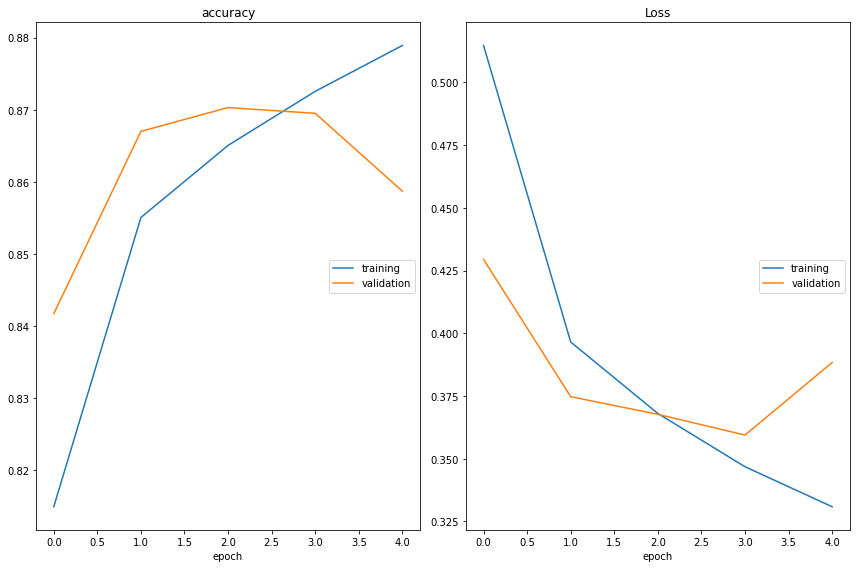

accuracy
	training         	 (min:    0.815, max:    0.879, cur:    0.879)
	validation       	 (min:    0.842, max:    0.870, cur:    0.859)
Loss
	training         	 (min:    0.331, max:    0.515, cur:    0.331)
	validation       	 (min:    0.359, max:    0.429, cur:    0.388)
1875/1875 [==============================] - 10s 5ms/step - loss: 0.3309 - accuracy: 0.8789 - val_loss: 0.3884 - val_accuracy: 0.8587


In [ ]:
# Load & Prepare Data
fashion_mnist = tf.keras.datasets.fashion_mnist
(x_train, y_train),(x_test, y_test) = fashion_mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# Define Model
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=(28, 28)))
model.add(tf.keras.layers.Dense(512, activation='relu')) 
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(10, activation='softmax'))

# Compile Model
model.compile(optimizer=optimizer, 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

# Train Model
model.fit(x=x_train, 
          y=y_train, 
          epochs=5, 
          validation_data=(x_test, y_test),
          callbacks=[PlotLossesKerasTF()],
          verbose=1)